TREATMENT OF MISSING VALUES

Algorithms which handle missing values


Some algprithms like XGBoost and LightGBM can handle missing values without any preprocessing, by supplying relevant parameters.

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

import missingno as msno

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


Target : Survived

In [5]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

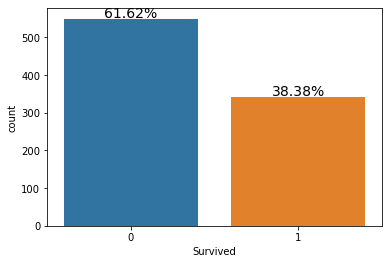

In [6]:
s = sns.countplot(x='Survived',data=train)
sizes=[]
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}%'.format(height/len(train)*100), ha='center',fontsize=14)

In [7]:
print(train.isnull().sum(), (train.isnull().sum() * 100)/891)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


In [8]:
print(test.isnull().sum(),(test.isnull().sum() * 100)/418)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64 PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64


Detecting missing data visually using Missingno library

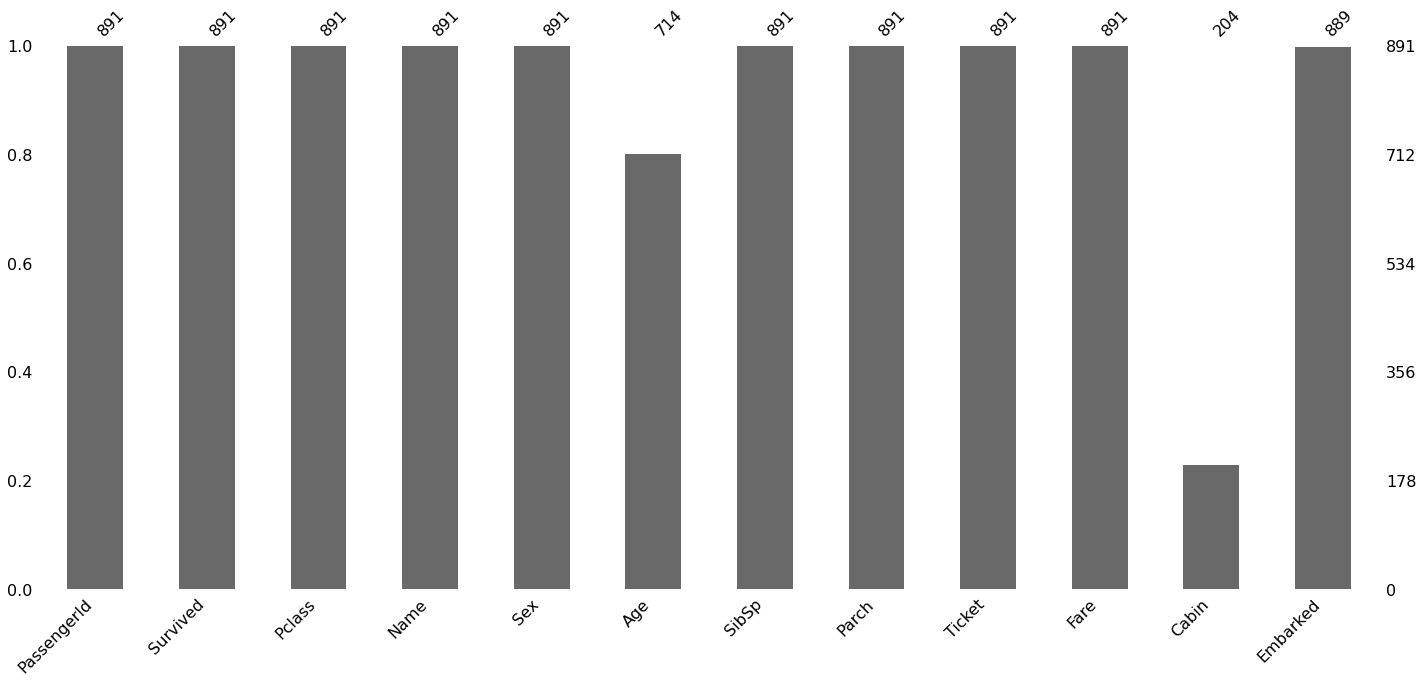

In [9]:
msno.bar(train)

Visualizing the locations of the missing data

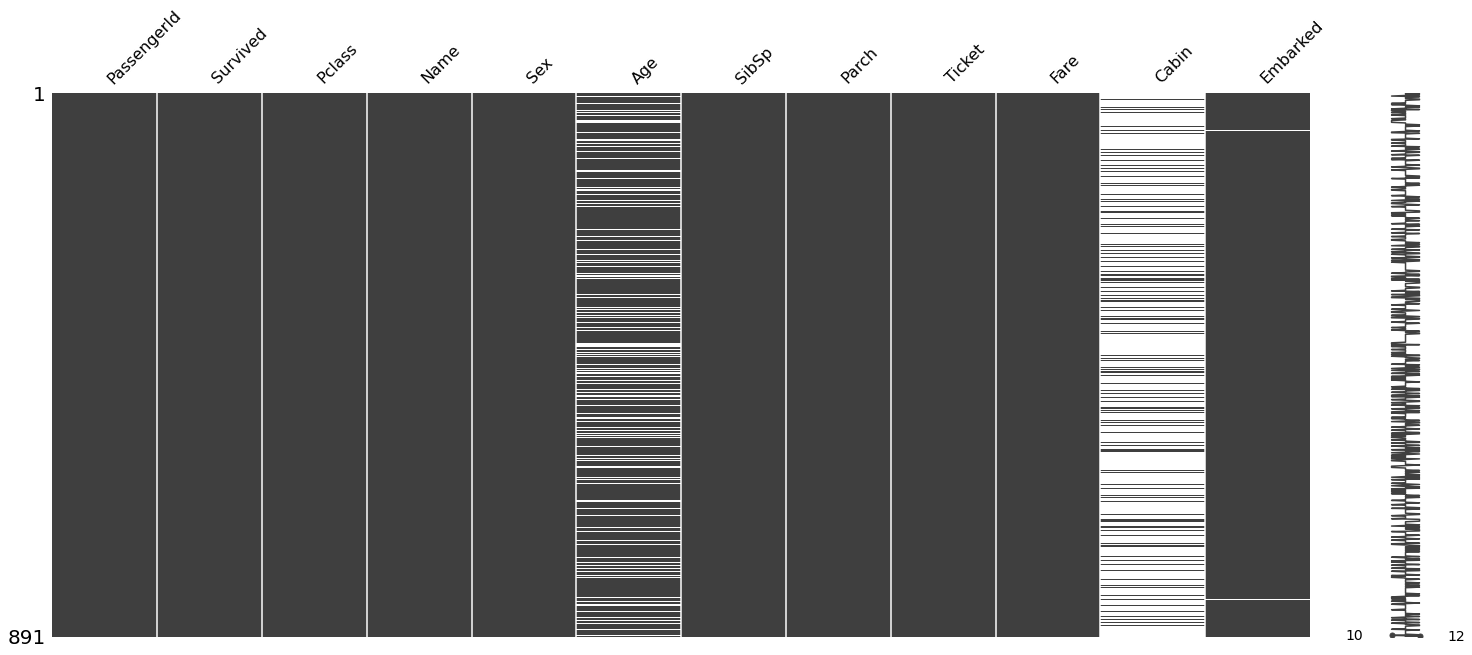

In [10]:
msno.matrix(train)

The plot appears blank(white) wherever there are missing values. For instance, in Embarked column there are only two instances of missing data, hence the two white lines.

The sparkline on the right gives an idea of the general shape of the completeness of the data and points out the row with the minimum nullities and the total number of columns in a given dataset, at the bottom.

It is also possible to sample the dataset to pinpoint the exact location of the missing values. For instance let's check the first 100 rows.

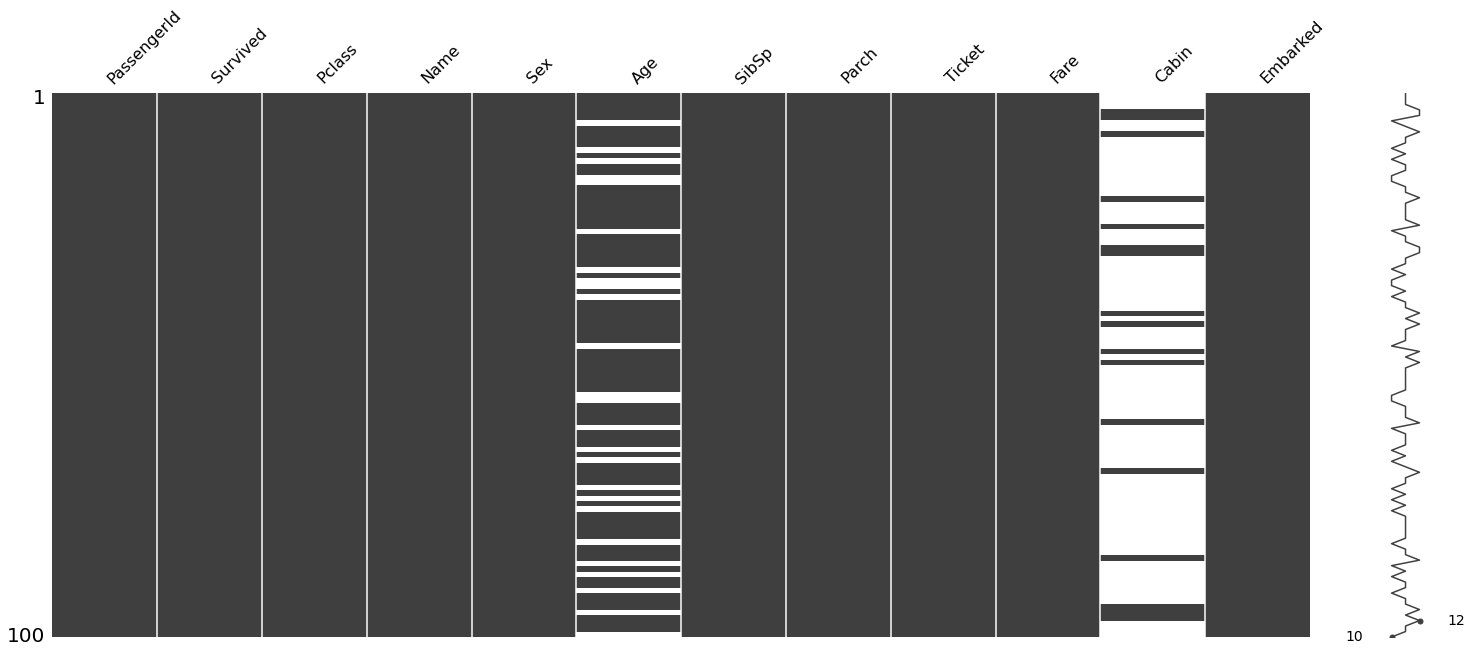

In [11]:
msno.matrix(train.sample(100))

This shows that the Embarked column has no nullity in the first 100 cases.

Reasons for Missing Values

Now let us look at nullity matrix again to see if can find what type of missingness is present in the dataset.

1. The Embarked Column has very few missing values and donot seem to be correlated with any other column, Hence, the missingness in Embarked column can be attributed as Missing Completely at Random.
2. Both the Age and the Cabin columns have a lot of missing values.This could be a case of MAR as we cannot directly observe the reason for missingness of data in these columns.

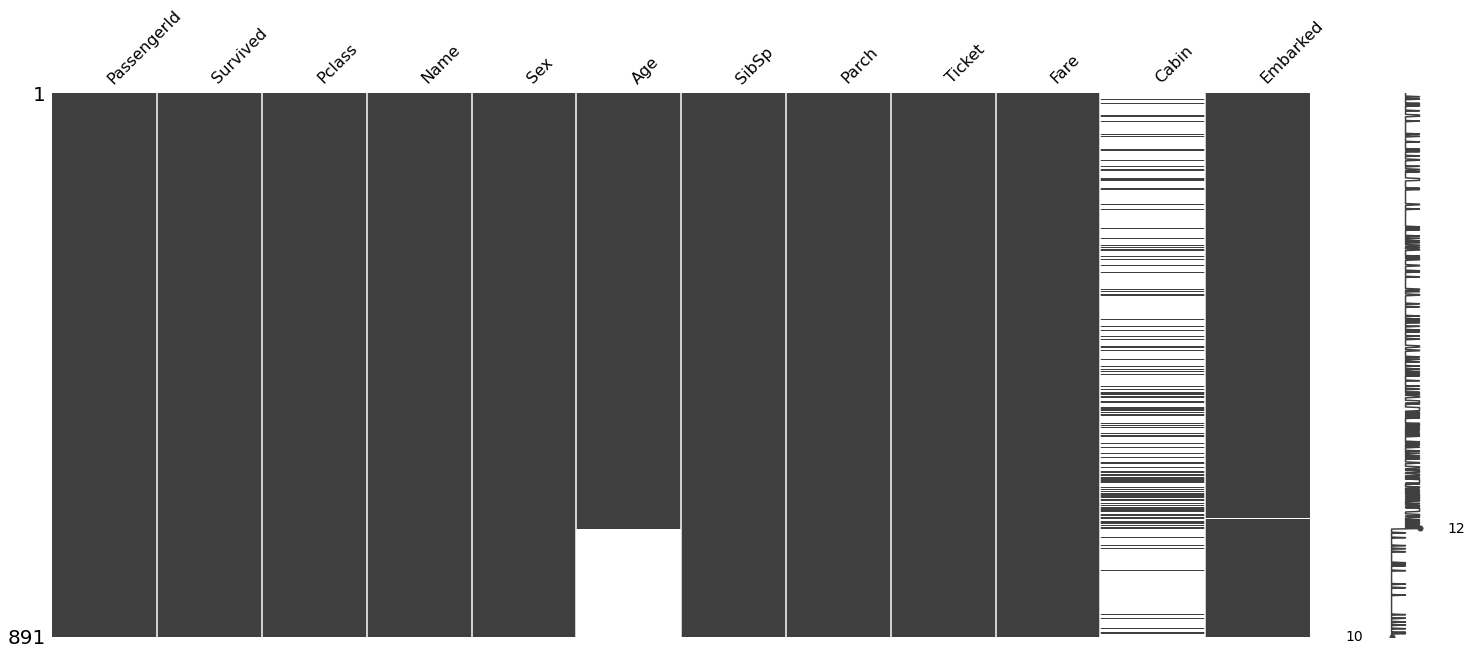

In [12]:
sorted = train.sort_values('Age')
msno.matrix(sorted)

Hence it is clear that here is no relation between the missingness in Age and Cabin column.To cement this conclusion further we can also draw a Heatmap among the different variables in the dataset.

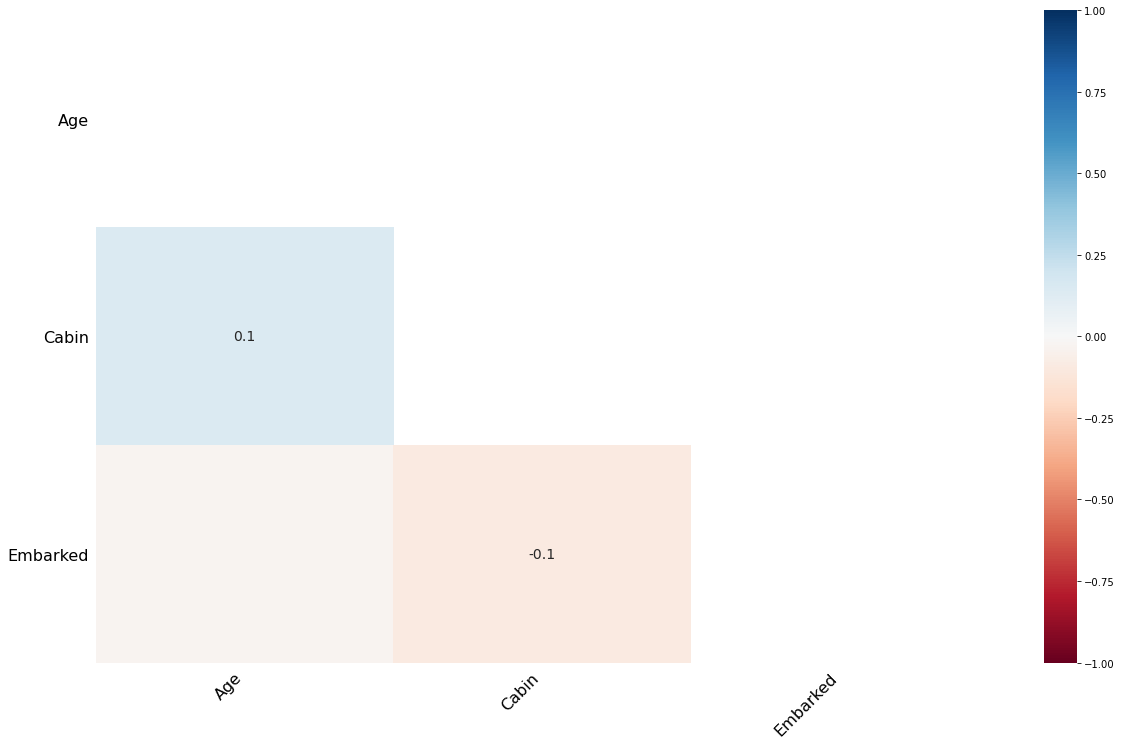

In [13]:
msno.heatmap(train)

The heatmap function shows that there are no strong correlations between missing values of different features. This is good; low correlations further indicate that the data are MAR.

Finding reason for missing data using Dendrogram

A dendogram is a tree diagram of missingness. It groups the highly correlated variables together.

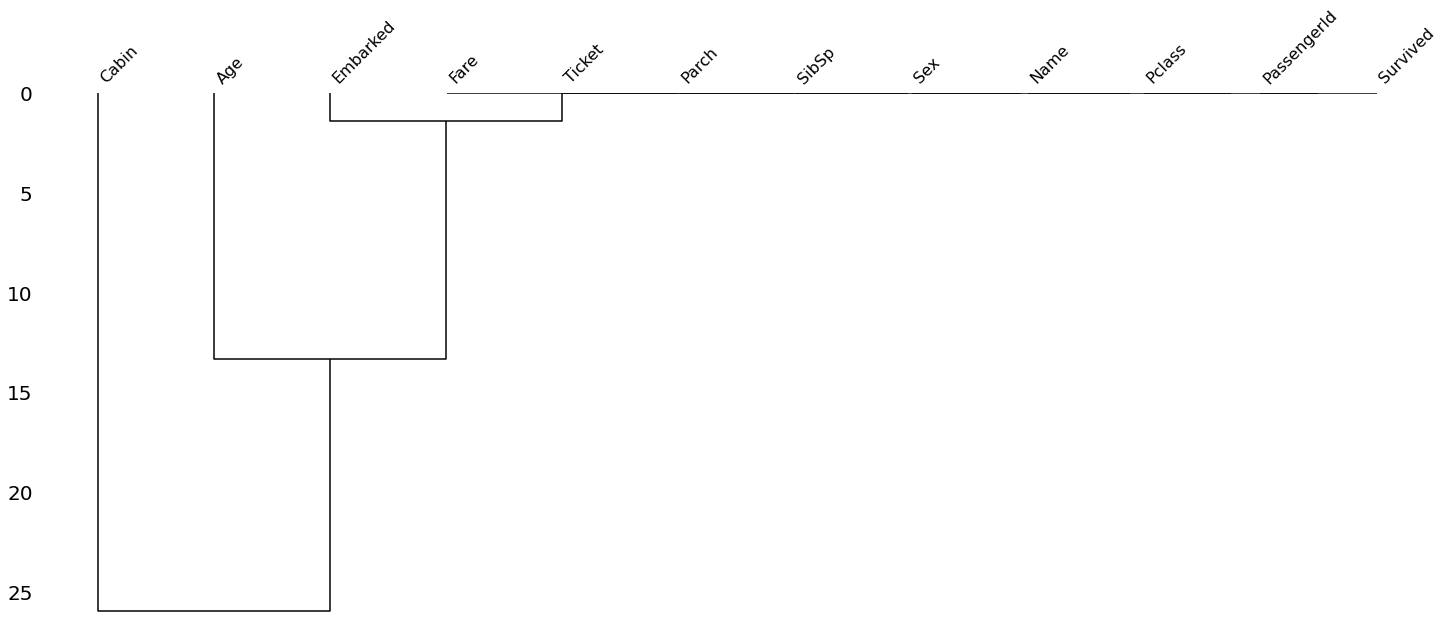

In [14]:
msno.dendrogram(train)

Let's read the above dendrogram from a top-down perspective:

1. Cluster leaves(from 'fare' to 'survived') which linked together at a distance of zero fully predict one another's presence—one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on(missingno documentation)
2. the missingness of Embarked tends to be more similar to Age than to Cabin and so on.However, in this particluar case, the correlation is high since Embarked column has a very few missing values.

Treatment

1. Deletions

a. Pairwise Deletion

Parwise Deletion is used when values are missing completely at random i.e MCAR. During Pairwise deletion, only the missing values are deleted. All operations in pandas like mean,sum etc intrinsically skip missing values.

In [15]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [17]:
train_1 = train.copy()
train_1['Age'].mean() #pandas skips the missing values and calculates mean of the remaining values.

29.69911764705882

b. Listwise Deletion

During Listwise deletion, complete rows(which contain the missing values) are deleted. As a result, it is also called Complete Case deletion. Like Pairwise deletion, listwise deletions are also only used for MCAR values.

The Age column doesn't have any missing values.A major diadvantage of Listwise deletion is that a major chunk of data and hence a lot of information is lost. Hence, it is advisable to use it only when the number of missing values is very small.

In [18]:
train_1.dropna(subset=['Age'],how='any',inplace=True)
train_1['Age'].isnull().sum()

0

c. Dropping complete columns
If a column contains a lot of missing values, say more than 80%, and the feature is not significant, you might want to delete that feature. However, again, it is not a good methodology to delete data.

2. Imputation for Non Time Series Data

a1. Imputations Techniques for non Time Series Problems

Basic Imputation Techniques:
1. Imputating with a constant value
2. Imputation using the statistics (mean, median or most     frequent) of each column in which the missing values are located

We shall use the SimpleImputer class from sklearn

In [20]:
from sklearn.impute import SimpleImputer

In [21]:
train_constant = train.copy()
#imputing using constant value
mean_imputer = SimpleImputer(strategy='constant')

train_constant.iloc[:,:] = mean_imputer.fit_transform(train_constant)
train_constant.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [23]:
train_most_frequent = train.copy()
#setting strategy to 'mean' to impute by the mean
mean_imputer = SimpleImputer(strategy='most_frequent')# strategy can also be mean or median 
train_most_frequent.iloc[:,:] = mean_imputer.fit_transform(train_most_frequent)
train_most_frequent.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

a2. Imputations Techniques for  Time Series Problems

 The fillna() method is used for imputing missing values in such problems.

1. 'ffill' or 'pad' - Replace NaN s with last observed value
2. 'bfill' or 'backfill' - Replace NaN s with next observed value
3. Linear interpolation method

In [25]:
city_day = pd.read_csv('city_day.csv')
city_day_copy = city_day.copy()
city_day.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [28]:
#Missing Values
city_day.isnull().sum()

City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64

In [30]:
(city_day.isnull().sum() *100)/29531

City           0.000000
Date           0.000000
PM2.5         15.570079
PM10          37.723071
NO            12.129626
NO2           12.139785
NOx           14.171549
NH3           34.973418
CO             6.972334
SO2           13.050692
O3            13.619586
Benzene       19.041008
Toluene       27.229014
Xylene        61.322001
AQI           15.851139
AQI_Bucket    15.851139
dtype: float64

In [31]:
# Imputation using ffill/pad
# Imputing Xylene value

city_day['Xylene'][50:64]

50     7.48
51    15.44
52     8.47
53    28.46
54     6.05
55     0.81
56      NaN
57      NaN
58      NaN
59     1.32
60     0.22
61     2.25
62     1.55
63     4.13
Name: Xylene, dtype: float64

We can see that all missing values have been filled with the last observed values.

In [33]:
city_day.fillna(method='ffill',inplace=True)
city_day['Xylene'][50:65]

50     7.48
51    15.44
52     8.47
53    28.46
54     6.05
55     0.81
56     0.81
57     0.81
58     0.81
59     1.32
60     0.22
61     2.25
62     1.55
63     4.13
64     4.13
Name: Xylene, dtype: float64

In [34]:
city_day['AQI'][20:30]

20      NaN
21      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28    209.0
29    328.0
Name: AQI, dtype: float64

We can see that all missing values have been filled with the next observed values.

In [35]:
##bfill
city_day.fillna(method='bfill',inplace=True)
city_day['AQI'][20:30]

20    209.0
21    209.0
22    209.0
23    209.0
24    209.0
25    209.0
26    209.0
27    209.0
28    209.0
29    328.0
Name: AQI, dtype: float64

#Linear Interpolation
1. A more apt alternative would be to use interpolation methods, where the values are filled with incrementing or decrementing values.

2. Linear interpolation is an imputation technique that assumes a linear relationship between data points and utilises non-missing values from adjacent data points to compute a value for a missing data point.

In [37]:
city_day_copy['Xylene'][50:65]

50     7.48
51    15.44
52     8.47
53    28.46
54     6.05
55     0.81
56      NaN
57      NaN
58      NaN
59     1.32
60     0.22
61     2.25
62     1.55
63     4.13
64      NaN
Name: Xylene, dtype: float64

In [38]:
# Interpolate using the linear method
city_day_copy.interpolate(limit_direction="both",inplace=True)
city_day_copy['Xylene'][50:65]

50     7.4800
51    15.4400
52     8.4700
53    28.4600
54     6.0500
55     0.8100
56     0.9375
57     1.0650
58     1.1925
59     1.3200
60     0.2200
61     2.2500
62     1.5500
63     4.1300
64     2.2600
Name: Xylene, dtype: float64

b. Advanced Imputation Technique

1. Nearest neighbors imputation

The KNNImputer class provides imputation for filling in missing values using the k-Nearest Neighbors approach.Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor.

In [40]:
train = pd.read_csv("train.csv")
train_knn = train.copy()

In [42]:
from sklearn.impute import KNNImputer
train_imputer = KNNImputer(n_neighbors=2,weights='uniform')
train_knn['Age'] = train_imputer.fit_transform(train_knn[['Age']])
train_knn['Age'].isnull().sum()

0

2. MICE ::: 
Multivariate feature imputation - Multivariate imputation by chained equations 

A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion. It performns multiple regressions over random sample ofthe data, then takes the average ofthe multiple regression values and uses that value to impute the missing value. In sklearn, it is implemented as follows:

In [44]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
train_mice = train.copy(deep=True)

mice_imputer = IterativeImputer()
train_mice['Age'] = mice_imputer.fit_transform(train_mice[['Age']])
train_mice['Age'].isnull().sum()

0

Links:

1. https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4
2. https://campus.datacamp.com/courses/dealing-with-missing-data-in-python/the-problem-with-missing-data?ex=1